In [1]:
!pip install kaggle

In [0]:
from getpass import getpass
import os
user = 'ahmadelsallab'
key = '6b7ffe97ff5bc0656e325b746b72fa31'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c ashrae-energy-prediction

 99% 118M/120M [00:11<00:00, 6.49MB/s]
100% 120M/120M [00:11<00:00, 10.9MB/s]
 98% 87.0M/88.4M [00:02<00:00, 28.0MB/s]
100% 88.4M/88.4M [00:02<00:00, 35.3MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 182MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 22.1MB/s]
 99% 165M/167M [00:09<00:00, 18.9MB/s]
100% 167M/167M [00:09<00:00, 17.6MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 38.7MB/s]


In [4]:
!unzip train.csv.zip
!unzip weather_train.csv.zip
!unzip building_metadata.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
unzip:  cannot find or open building_metadata.csv.zip, building_metadata.csv.zip.zip or building_metadata.csv.zip.ZIP.


In [0]:
import pandas as pd
train_df = pd.merge(pd.merge(pd.read_csv('train.csv'), pd.read_csv('building_metadata.csv'), on='building_id', how='left'), pd.read_csv('weather_train.csv'), on=['timestamp','site_id'], how='left')



In [0]:
import numpy as np

train_df.meter_reading = train_df.meter_reading.apply(np.log1p)


In [0]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 752.28 MB
Decreased by 71.3%


In [0]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [10]:
description(train_df)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float16,0,8494,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,96658,619,25,25,25


Derived features

In [0]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df["hour"] = train_df["timestamp"].dt.hour
train_df["day"] = train_df["timestamp"].dt.day
train_df["weekday"] = train_df["timestamp"].dt.weekday_name 
train_df["month"] = train_df["timestamp"].dt.month
train_df['year'] = train_df['timestamp'].dt.year

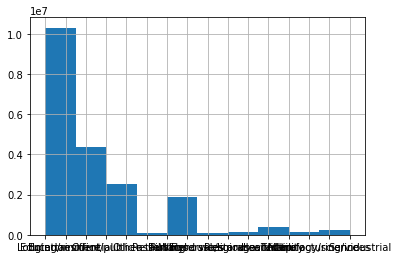

In [12]:
train_df.primary_use.hist()

In [13]:
train_df.head()


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,year
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016


Season feature

In [0]:
month_to_season = lambda month:(month%12 + 3)//3

In [15]:
[month_to_season(month) for month in range(1, 13)]

[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

In [0]:
train_df['season'] = train_df.month.apply(month_to_season)


In [17]:
import seaborn as sns

sns.heatmap(train_df.corr(), 
            xticklabels=train_df.corr().columns.values,
            yticklabels=train_df.corr().columns.values)

KeyboardInterrupt: ignored

In [0]:
sns.set_style("whitegrid")
sns.countplot(train_df.primary_use)

In [0]:
# To make the labels names apearing --> rotate by 45
chart = sns.countplot(train_df.primary_use)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [0]:
# To make the labels names apearing --> rotate by 45 + align to avoid entanglement
chart = sns.countplot(train_df.primary_use)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [0]:
chart = sns.countplot(train_df.primary_use)
# Bigger font
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light',fontsize='x-large')

In [0]:
# Could also be done with matplotlib directly
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.countplot(train_df.primary_use)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

See more on data vis at: https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib

In [0]:
import lightgbm as lgb

https://sefiks.com/2018/10/13/a-gentle-introduction-to-lightgbm-for-applied-machine-learning/


In [0]:
y_train = train_df.meter_reading

In [0]:
x_train = train_df.drop(col)